# Research goal: Analyze diamonds by their cut, color, clarity, price, and other attributes.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy import stats
from scipy.stats import norm
import statistics
import statsmodels.api as sm
import pylab as py

import plotly.express as px

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("/content/diamonds.csv")
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.230,Ideal,E,SI2,61.500,55.000,326,3.950,3.980,2.430
1,2,0.210,Premium,E,SI1,59.800,61.000,326,3.890,3.840,2.310
2,3,0.230,Good,E,VS1,56.900,65.000,327,4.050,4.070,2.310
3,4,0.290,Premium,I,VS2,62.400,58.000,334,4.200,4.230,2.630
4,5,0.310,Good,J,SI2,63.300,58.000,335,4.340,4.350,2.750


# Understanding the features:

* The dataset contains the prices and other attributes of nearly 54,000 diamonds. There are 10 attributes

* Feature description:

* price: It ranges from $18,823 and $326.This is our outcome or dependent variable (target variable)--> y

* cut : It is related to physical attribute of diamonds and it is a categorical and ordinal variable.We can think that it is related to quality. --> Fair < Good < Very Good < Premium < Ideal

* color : J (worst) to D (best) - it is a categorical and ordinal variable

* carat : The carat is related to the diamond’s physical weight. It ranges from 0.2 and 5.01.

* clarity : I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best) --> it is a categorical and ordinal variable.

* Dimensions -> x,y,z

* x : length in mm (0--10.74)
* y : width in mm (0--58.9)
* z : depth in mm (0--31.8)

* depth : total depth percentage = z / mean(x, y) = 2 * z / (x + y) --> it ranges from (43--79)

* table : width of top of diamond relative to widest point (43--95) -> continious varible

![pic](https://gcdnb.pbrd.co/images/2PRTin9PrjbR.jpg?o=1)

**Dictionary of the 3 categorical features:**

| feature name | order | values |
| --- |: --- :| --- |
| Diamond cut quality | ascending  | {Fair, Good, Very Good, Premium, Ideal} |
| diamond color | descending | {D , E , F , G , H , I , J} |
| Diamond Clarity | ascending | {I1 , SI2 , SI1 , VS2 , VS1 , VVS2 , VVS1 , IF} |

## Basic Data Exploration

In [3]:
df = df.drop(columns = "Unnamed: 0")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.230,Ideal,E,SI2,61.500,55.000,326,3.950,3.980,2.430
1,0.210,Premium,E,SI1,59.800,61.000,326,3.890,3.840,2.310
2,0.230,Good,E,VS1,56.900,65.000,327,4.050,4.070,2.310
3,0.290,Premium,I,VS2,62.400,58.000,334,4.200,4.230,2.630
4,0.310,Good,J,SI2,63.300,58.000,335,4.340,4.350,2.750


In [4]:
df.shape

(53940, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000,53940.000,53940.000,53940.000,53940.000,53940.000,53940.000
mean,0.798,61.749,57.457,3932.800,5.731,5.735,3.539
std,0.474,1.433,2.234,3989.440,1.122,1.142,0.706
min,0.200,43.000,43.000,326.000,0.000,0.000,0.000
25%,0.400,61.000,56.000,950.000,4.710,4.720,2.910
50%,0.700,61.800,57.000,2401.000,5.700,5.710,3.530
75%,1.040,62.500,59.000,5324.250,6.540,6.540,4.040
max,5.010,79.000,95.000,18823.000,10.740,58.900,31.800


In [7]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [8]:
df = df.drop_duplicates()

## Outlier Analysis Function

In [9]:
#Tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr

    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence

    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence

    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss

## Hypothesis Testing Function

In [10]:
def hypotesis_testing(data, value, variable):
    frame=data[[variable, value]]
    formula=f'{value} ~ {variable}'
    model=ols(formula, frame).fit()
    print(model.summary(), "\n", "#"*50)

    p_value=np.round(model.f_pvalue, 3)
    print("p_value:", p_value)

    if p_value<0.05:
        print("Reject Null Hypothesis and accept the alternate hypothesis")
    else:
        print("Accept the Null Hypothesis")

## Data Analysis

In [11]:
df.describe(include = "number")

,carat,depth,table,price,x,y,z
count,53794.000,53794.000,53794.000,53794.000,53794.000,53794.000,53794.000
mean,0.798,61.748,57.458,3933.065,5.731,5.735,3.539
std,0.473,1.430,2.234,3988.114,1.121,1.141,0.705
min,0.200,43.000,43.000,326.000,0.000,0.000,0.000
25%,0.400,61.000,56.000,951.000,4.710,4.720,2.910
50%,0.700,61.800,57.000,2401.000,5.700,5.710,3.530
75%,1.040,62.500,59.000,5326.750,6.540,6.540,4.030
max,5.010,79.000,95.000,18823.000,10.740,58.900,31.800


In [12]:
df.describe(include = "object")

,cut,color,clarity
count,53794,53794,53794
unique,5,7,8
top,Ideal,G,SI1
freq,21488,11262,13032


In [13]:
df_quant = df[["carat", "depth", "table", "price", "x", "y", "z"]]
df_quant.head()

,carat,depth,table,price,x,y,z
0,0.230,61.500,55.000,326,3.950,3.980,2.430
1,0.210,59.800,61.000,326,3.890,3.840,2.310
2,0.230,56.900,65.000,327,4.050,4.070,2.310
3,0.290,62.400,58.000,334,4.200,4.230,2.630
4,0.310,63.300,58.000,335,4.340,4.350,2.750


In [14]:
df_qual = df[["cut", "color", "clarity"]]
df_qual.head()

,cut,color,clarity
0,Ideal,E,SI2
1,Premium,E,SI1
2,Good,E,VS1
3,Premium,I,VS2
4,Good,J,SI2


In [15]:
for col in ['color','cut', 'clarity']:
    print(df_qual[col].value_counts())
    print('='*30)

G    11262
E     9776
F     9520
H     8272
D     6755
I     5407
J     2802
Name: color, dtype: int64
Ideal        21488
Premium      13748
Very Good    12069
Good          4891
Fair          1598
Name: cut, dtype: int64
SI1     13032
VS2     12229
SI2      9150
VS1      8156
VVS2     5056
VVS1     3647
IF       1784
I1        740
Name: clarity, dtype: int64


## Handling Outliers

In [16]:
for col in df_quant.columns:
  print(col, tukeys_method(df_quant, col))

carat ([16245, 19298, 19305, 21713, 21816, 22378, 22490, 22691, 22780, 23486, 23591, 24076, 24241, 24272, 24760, 25402, 25792, 25939, 25940, 26040, 26370, 26383, 26406, 26473, 26681, 26869, 26870, 27065, 27350, 27449, 27450, 27451, 27563, 27571, 27582, 27612, 27617, 27618], [11606, 12218, 12971, 13087, 13726, 13897, 13959, 13960, 14105, 14612, 14879, 14880, 15116, 15283, 15647, 15744, 15778, 15824, 15828, 15829, 15868, 15903, 15904, 16219, 16245, 16260, 16289, 16303, 16401, 16458, 16466, 16467, 16599, 16747, 16877, 16986, 17059, 17126, 17142, 17157, 17427, 17442, 17447, 17450, 17520, 17651, 17819, 17857, 17916, 17920, 18027, 18191, 18233, 18419, 18977, 19040, 19142, 19176, 19290, 19298, 19305, 19365, 19417, 19418, 19557, 19600, 19806, 19824, 19852, 19879, 19904, 20157, 20251, 20255, 20295, 20385, 20420, 20510, 20616, 20762, 20795, 20808, 20817, 20834, 20934, 21094, 21236, 21237, 21286, 21294, 21404, 21469, 21505, 21508, 21509, 21510, 21522, 21580, 21585, 21586, 21588, 21632, 21675, 216

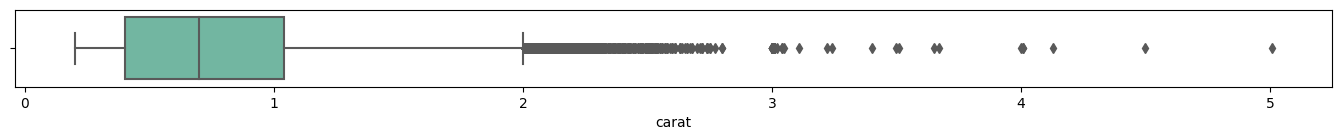

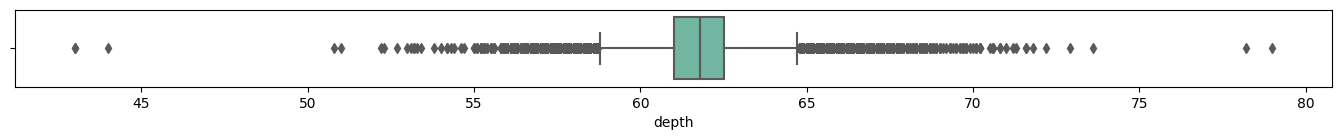

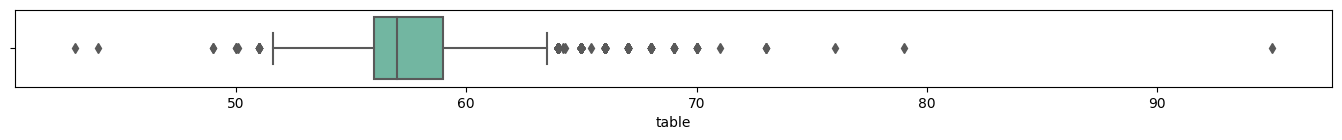

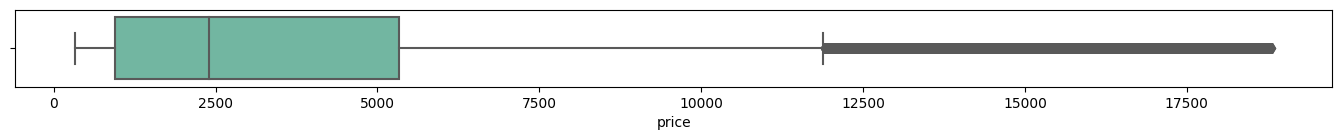

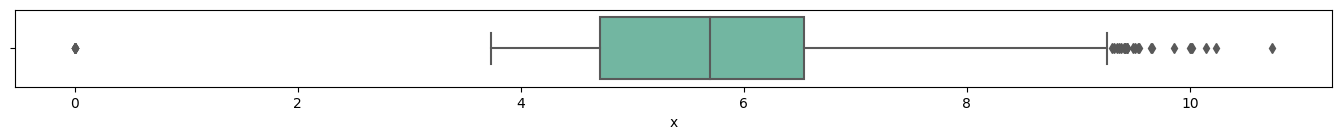

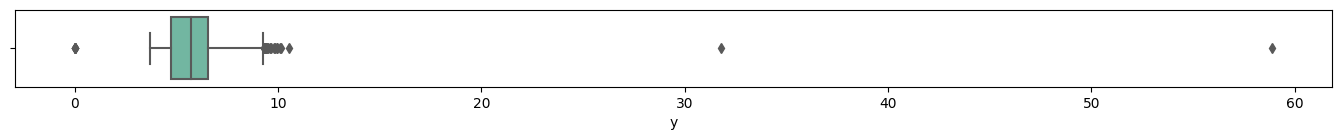

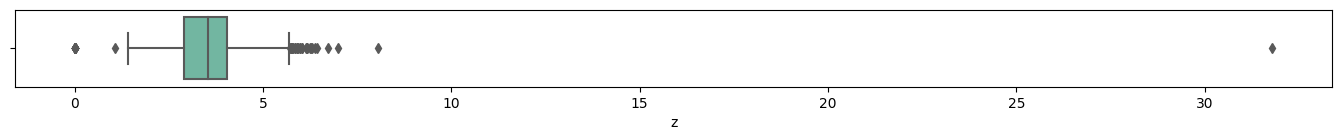

In [17]:
for column in df_quant:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df_quant, orient="h", palette="Set2", x=column)

In [18]:
for col in df_quant.columns:
  q1 = df_quant[col].quantile(0.25)
  q3 = df_quant[col].quantile(0.75)
  iqr = q3 - q1
  whisker_width = 1.5
  lower_whisker = q1 - (whisker_width * iqr)
  upper_whisker = q3 + whisker_width * iqr
  df_quant[col] = np.where(df_quant[col] > upper_whisker, upper_whisker, np.where(df_quant[col] < lower_whisker, lower_whisker, df_quant[col]))

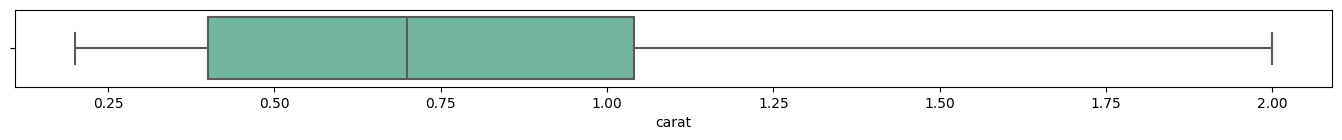

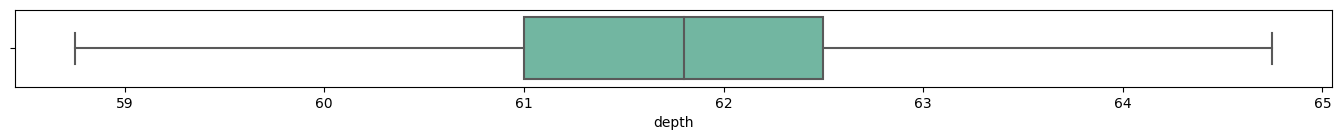

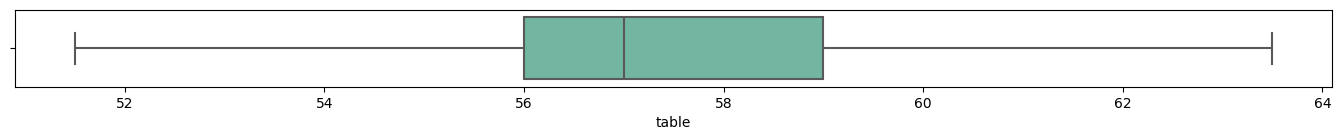

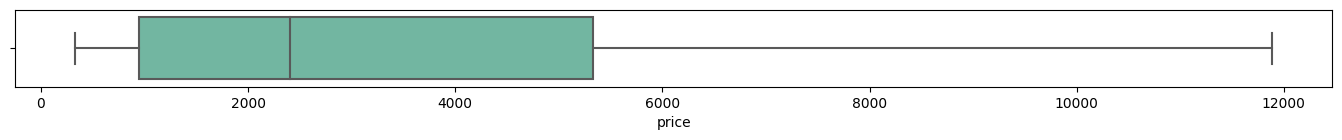

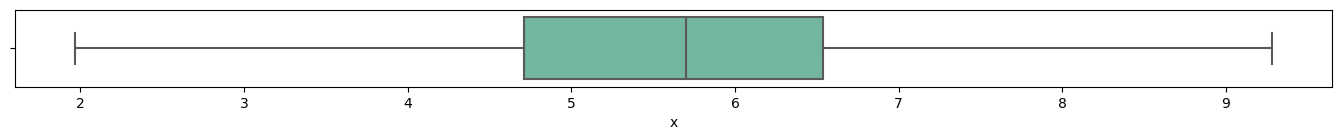

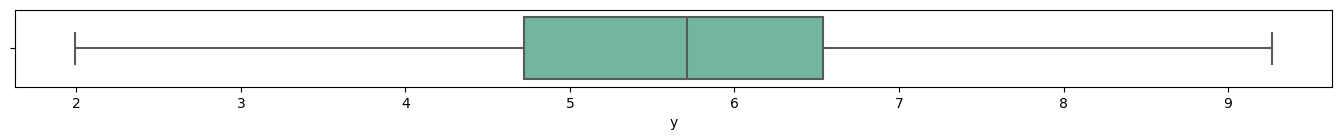

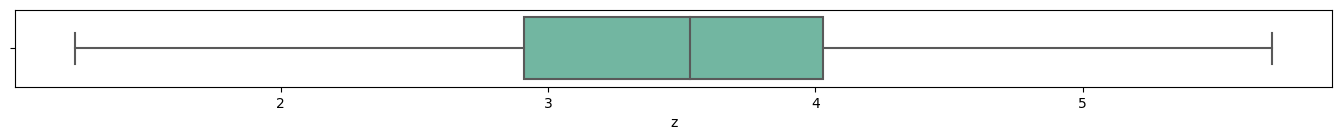

In [19]:
for column in df_quant:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df_quant, orient="h", palette="Set2", x=column)

In [20]:
df_quant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53794 entries, 0 to 53939
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   carat   53794 non-null  float64
 1   depth   53794 non-null  float64
 2   table   53794 non-null  float64
 3   price   53794 non-null  float64
 4   x       53794 non-null  float64
 5   y       53794 non-null  float64
 6   z       53794 non-null  float64
dtypes: float64(7)
memory usage: 3.3 MB


### Exploratory Data Analysis

#### Custom Palette for Visualization

In [21]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#f2d4b1","figure.facecolor":"#f2d4b1","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

palette = ["#c94727","#ea5b17","#e57716","#f2a324","#a2c0a6","#7ac0a8","#5e9786","#557260"]

# sns.palplot(sns.color_palette(palette))
# plt.show()

Let's have a look on the distribution of prices :


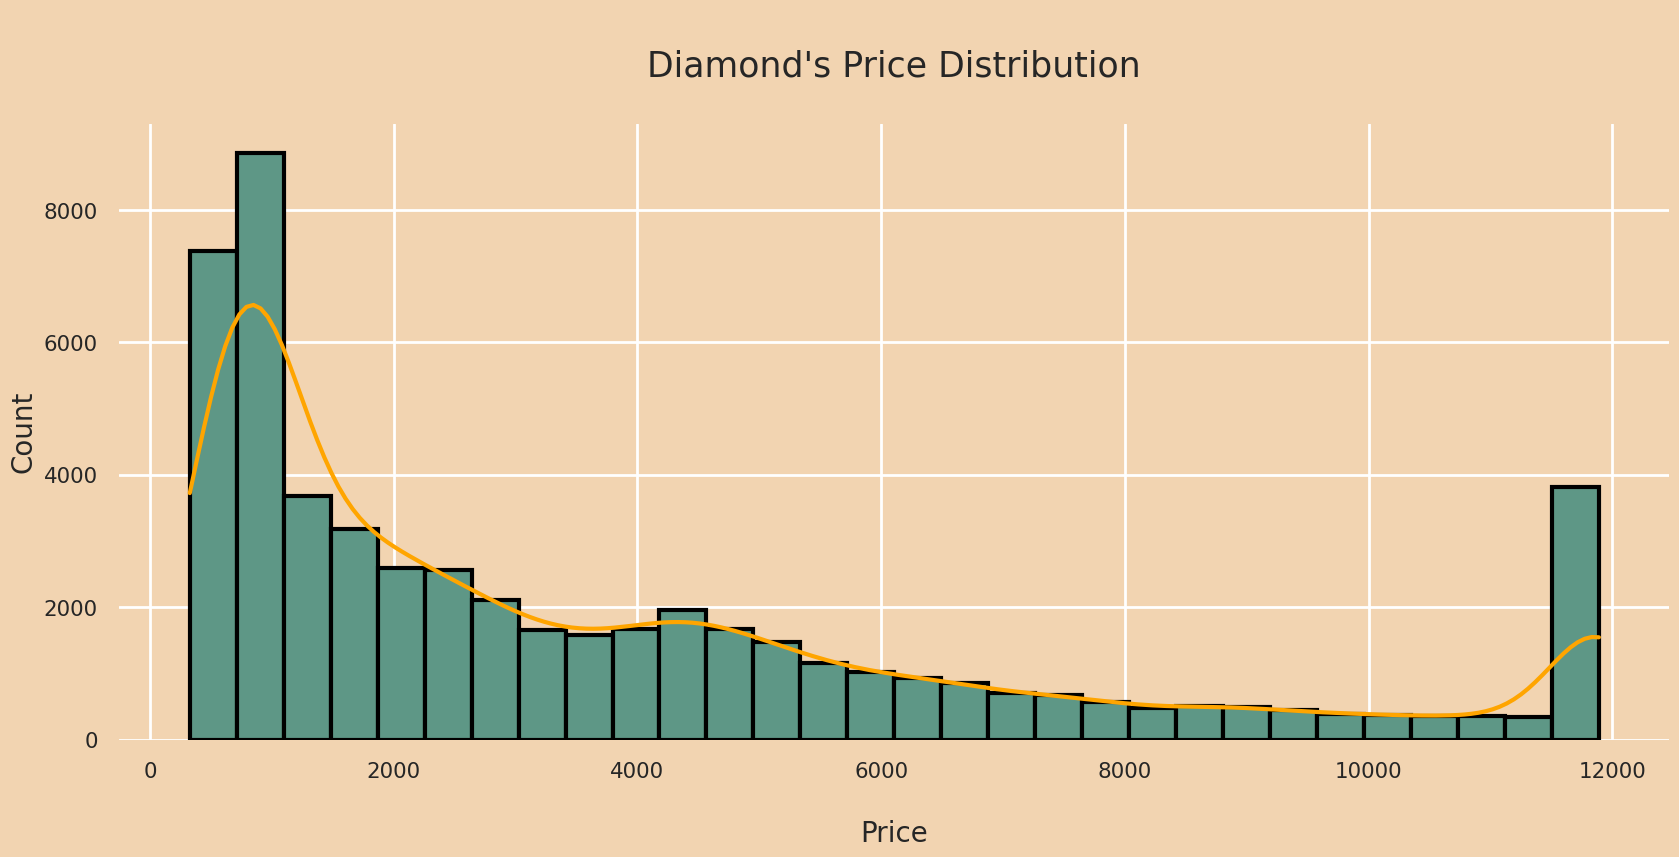

In [22]:
print(f"Let's have a look on the distribution of prices :")
plt.subplots(figsize=(20, 8))
p = sns.histplot(df_quant["price"],color=palette[6],kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color("orange")
p.axes.set_title("\nDiamond's Price Distribution\n",fontsize=25)
plt.ylabel("Count",fontsize=20)
plt.xlabel("\nPrice",fontsize=20)
plt.yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

Let's have a look on the ratio of diamond's cut :


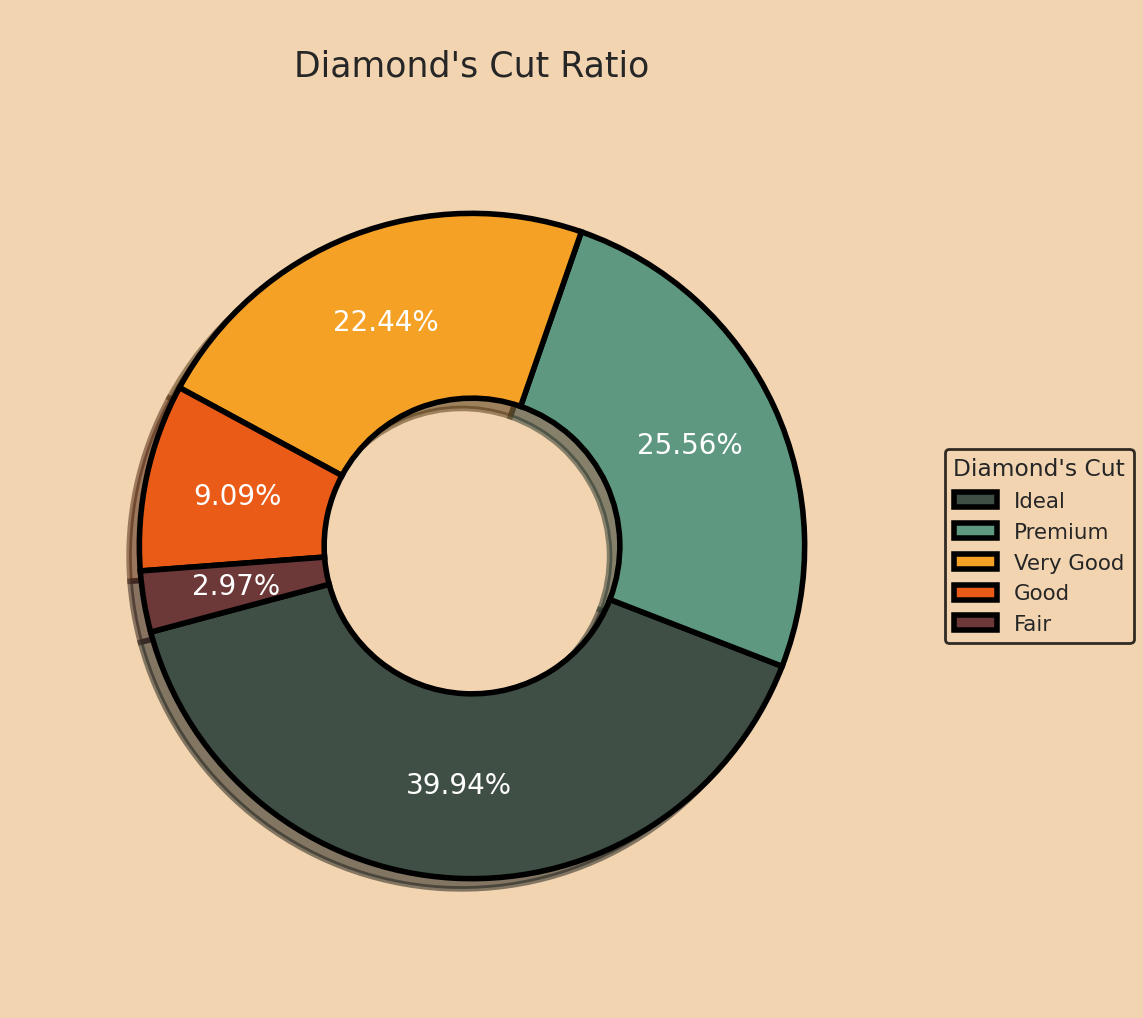

In [23]:
print(f"Let's have a look on the ratio of diamond's cut :")
plt.subplots(figsize=(12, 12))

labels = "Ideal","Premium","Very Good","Good","Fair"
size = 0.5

wedges, texts, autotexts = plt.pie([df_qual["cut"].value_counts().values[0],
                                    df_qual["cut"].value_counts().values[1],
                                    df_qual["cut"].value_counts().values[2],
                                    df_qual["cut"].value_counts().values[3],
                                    df_qual["cut"].value_counts().values[4]],
                                    explode = (0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%",
                                    pctdistance = 0.72,
                                    radius=.9,
                                    colors = ["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"],
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "black",
                                    linewidth = 4),
                                    startangle = -165)

plt.legend(wedges, labels, title="Diamond's Cut",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), edgecolor = "black")
plt.title("\nDiamond's Cut Ratio",fontsize=25)
plt.show()

Let's have a look on the diamond's cut :


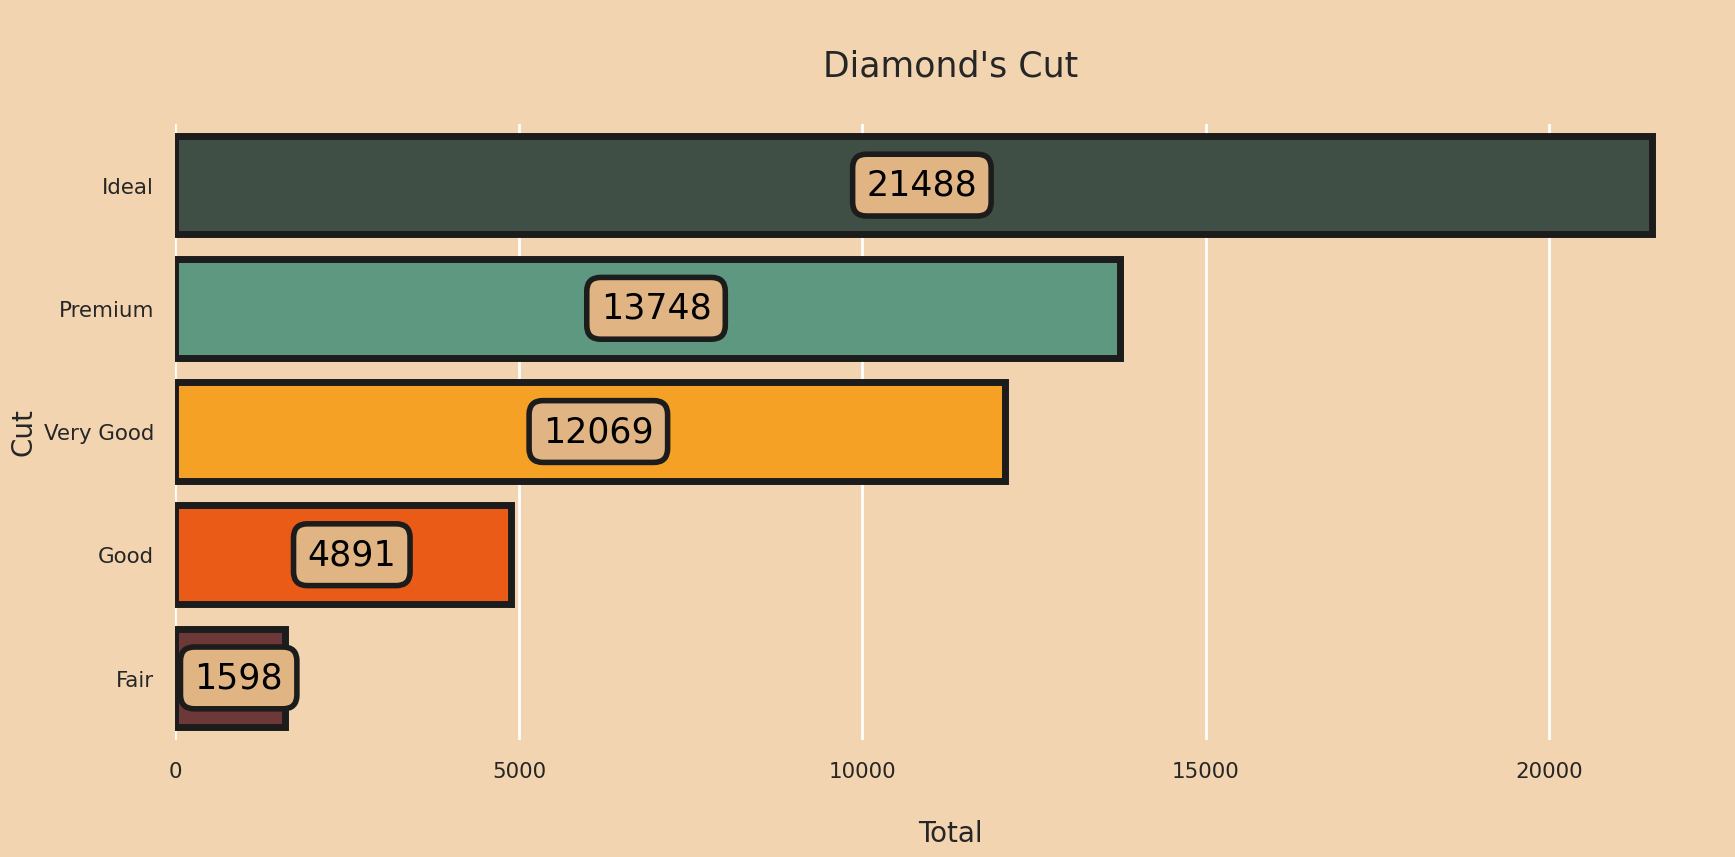

In [24]:
print("Let's have a look on the diamond's cut :")
plt.subplots(figsize=(20, 8))
p=sns.countplot(y=df_qual["cut"],order=df_qual["cut"].value_counts().index,palette=["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nDiamond's Cut\n",fontsize=25)
p.axes.set_ylabel("Cut",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=25,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.4, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the price distribution of diamond's cut :


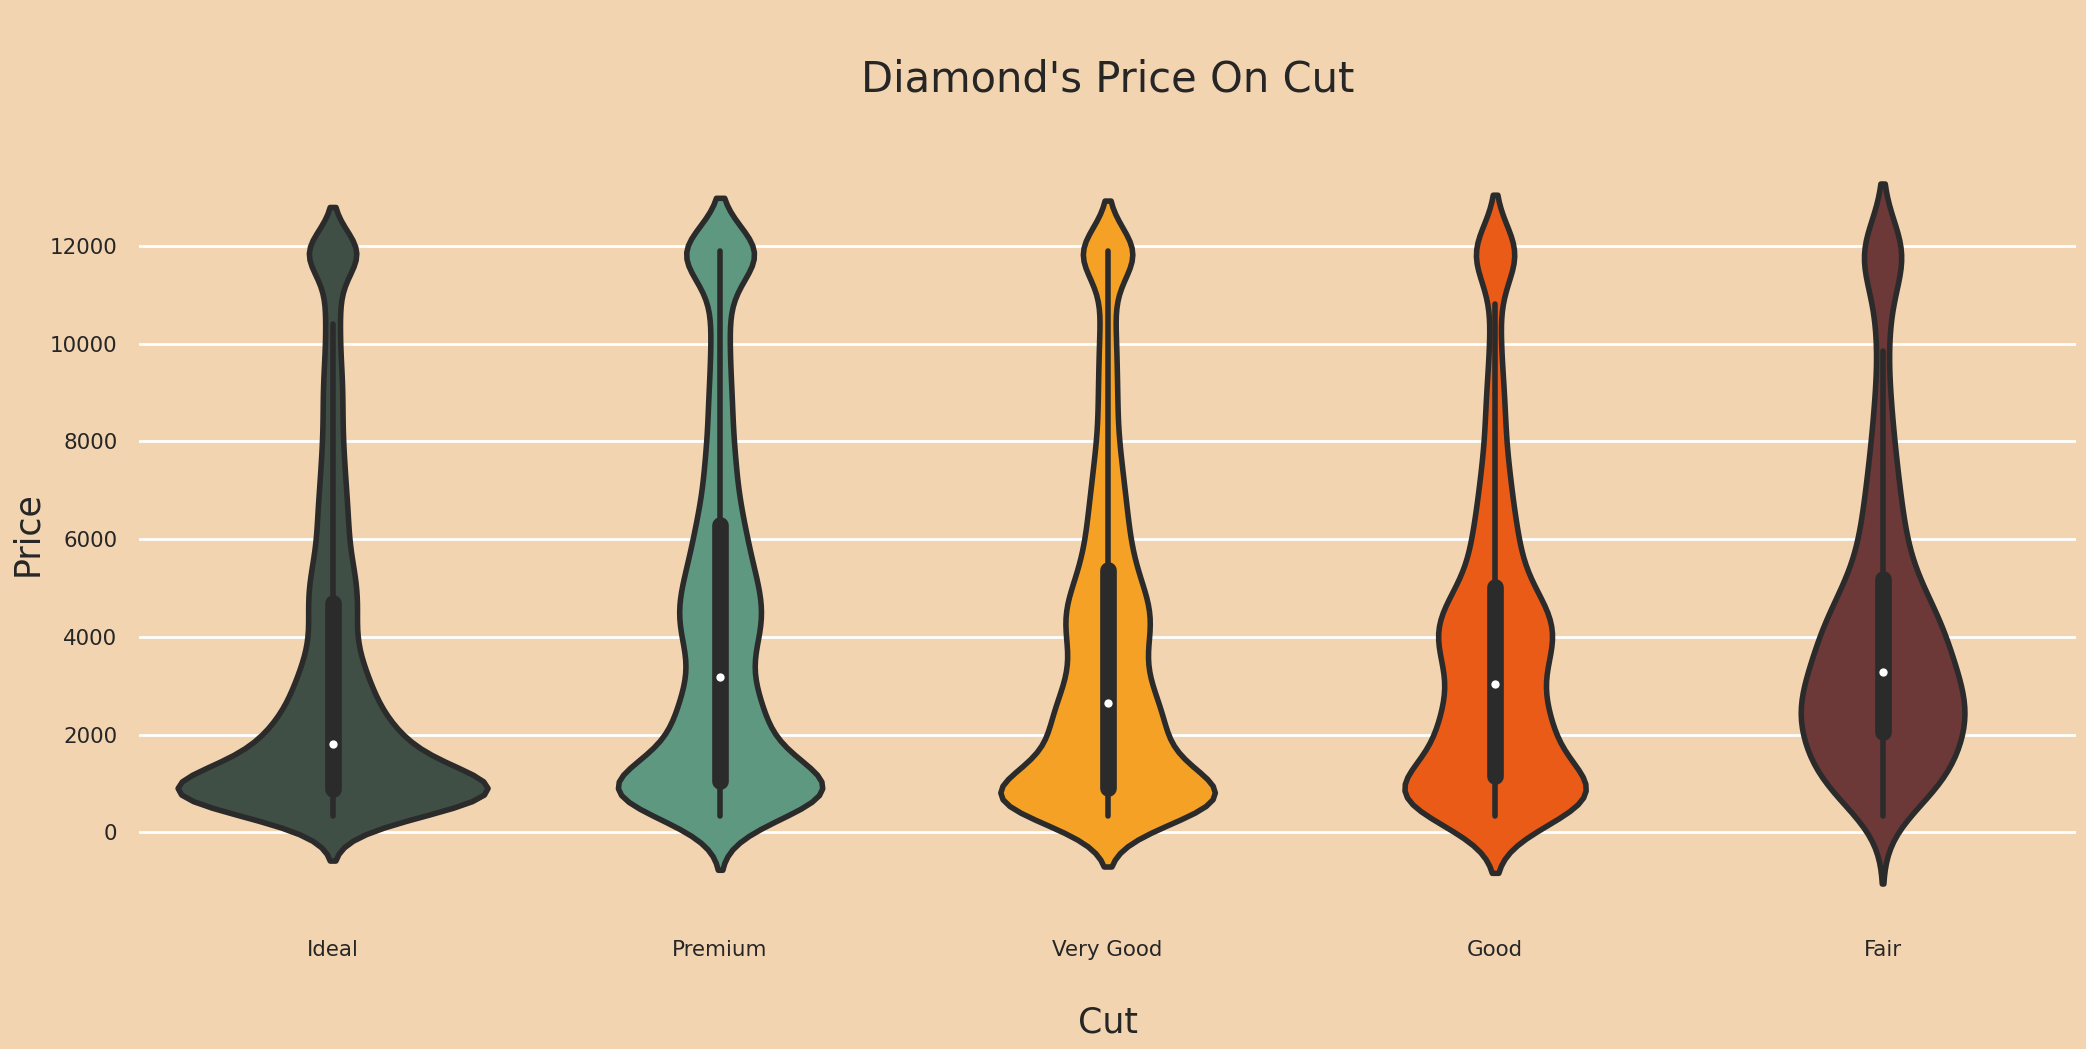

In [26]:
print("Let's have a look on the price distribution of diamond's cut :")
plt.subplots(figsize=(25, 10))

p=sns.violinplot(x=df_qual["cut"],y=df_quant["price"],order=df_qual["cut"].value_counts().index,palette=["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"],saturation=1,linewidth=4,edgecolor="black")
p.axes.set_title("\nDiamond's Price On Cut\n",fontsize=30)
p.axes.set_xlabel("\nCut",fontsize=25)
p.axes.set_ylabel("Price",fontsize=25)

sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the ratio of diamond's color :


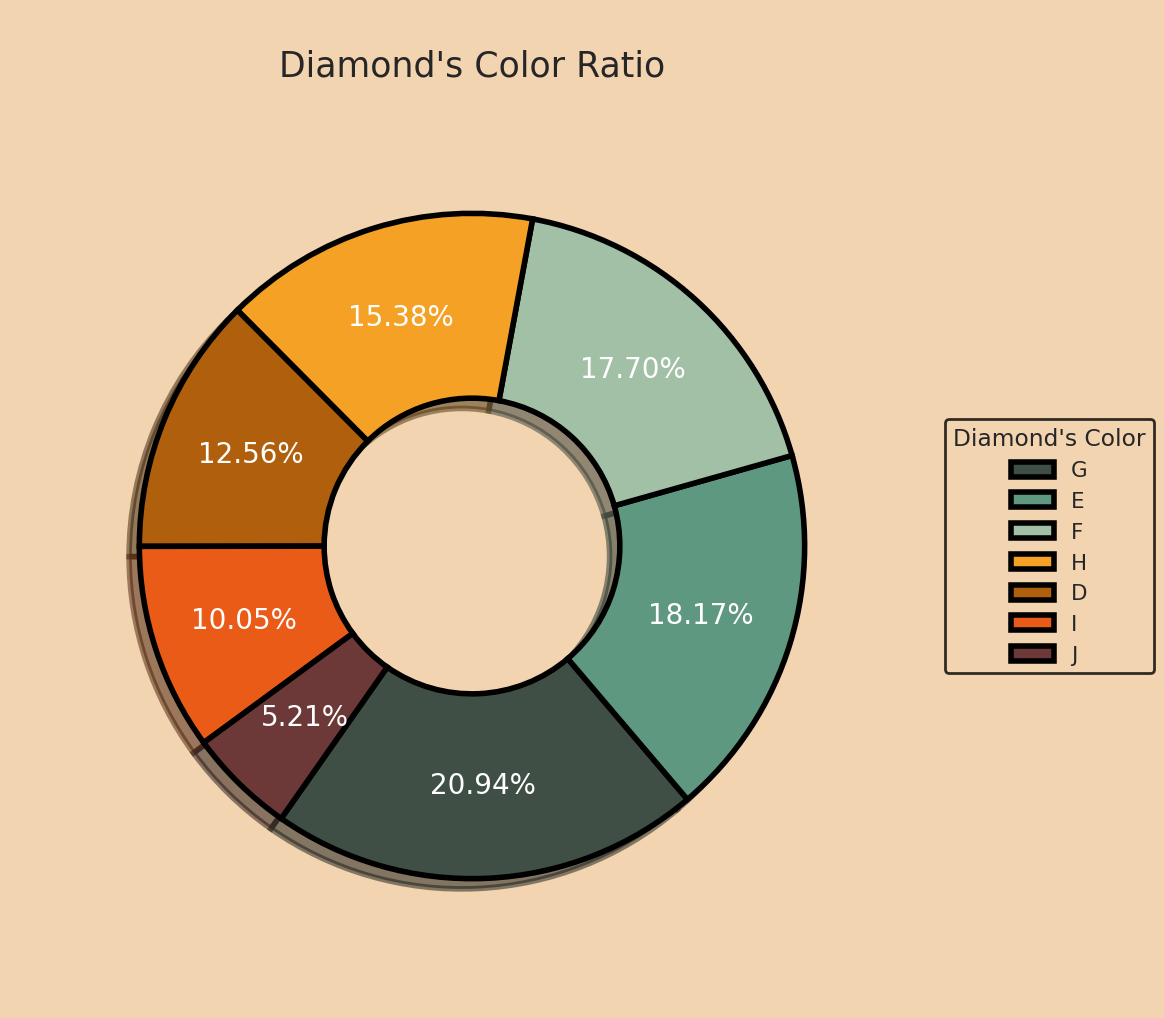

In [27]:
print(f"Let's have a look on the ratio of diamond's color :")
plt.subplots(figsize=(12, 12))

labels = "G","E","F","H","D","I","J"
size = 0.5

wedges, texts, autotexts = plt.pie([df_qual["color"].value_counts().values[0],
                                    df_qual["color"].value_counts().values[1],
                                    df_qual["color"].value_counts().values[2],
                                    df_qual["color"].value_counts().values[3],
                                    df_qual["color"].value_counts().values[4],
                                    df_qual["color"].value_counts().values[5],
                                    df_qual["color"].value_counts().values[6]],
                                    explode = (0,0,0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%",
                                    pctdistance = 0.72,
                                    radius=.9,
                                    colors = ["#3f4f45","#5e9880","#a2c0a6","#f5a126","#b05f0d","#ea5b17","#6c3938"],
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "black",
                                    linewidth = 4),
                                    startangle = -125)

plt.legend(wedges, labels, title="Diamond's Color",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), edgecolor = "black")
plt.title("\nDiamond's Color Ratio",fontsize=25)
plt.show()

Let's have a look on the diamond's color :


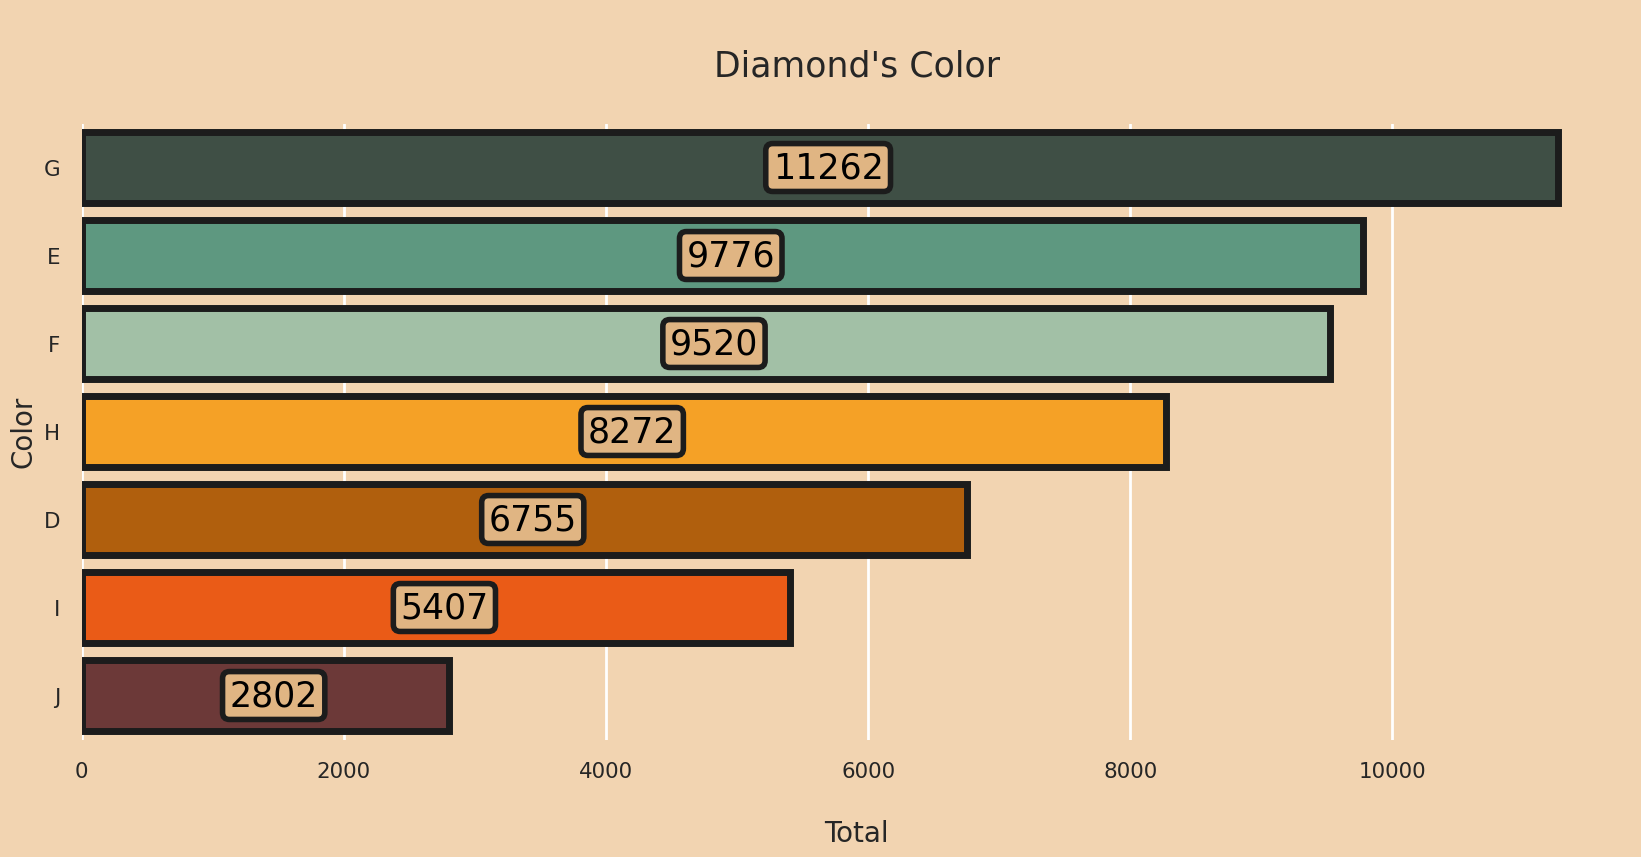

In [28]:
print("Let's have a look on the diamond's color :")
plt.subplots(figsize=(20, 8))
p=sns.countplot(y=df_qual["color"],order=df_qual["color"].value_counts().index,palette=["#3f4f45","#5e9880","#a2c0a6","#f5a126","#b05f0d","#ea5b17","#6c3938"], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nDiamond's Color\n",fontsize=25)
p.axes.set_ylabel("Color",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=25,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the price distribution of diamond's color :


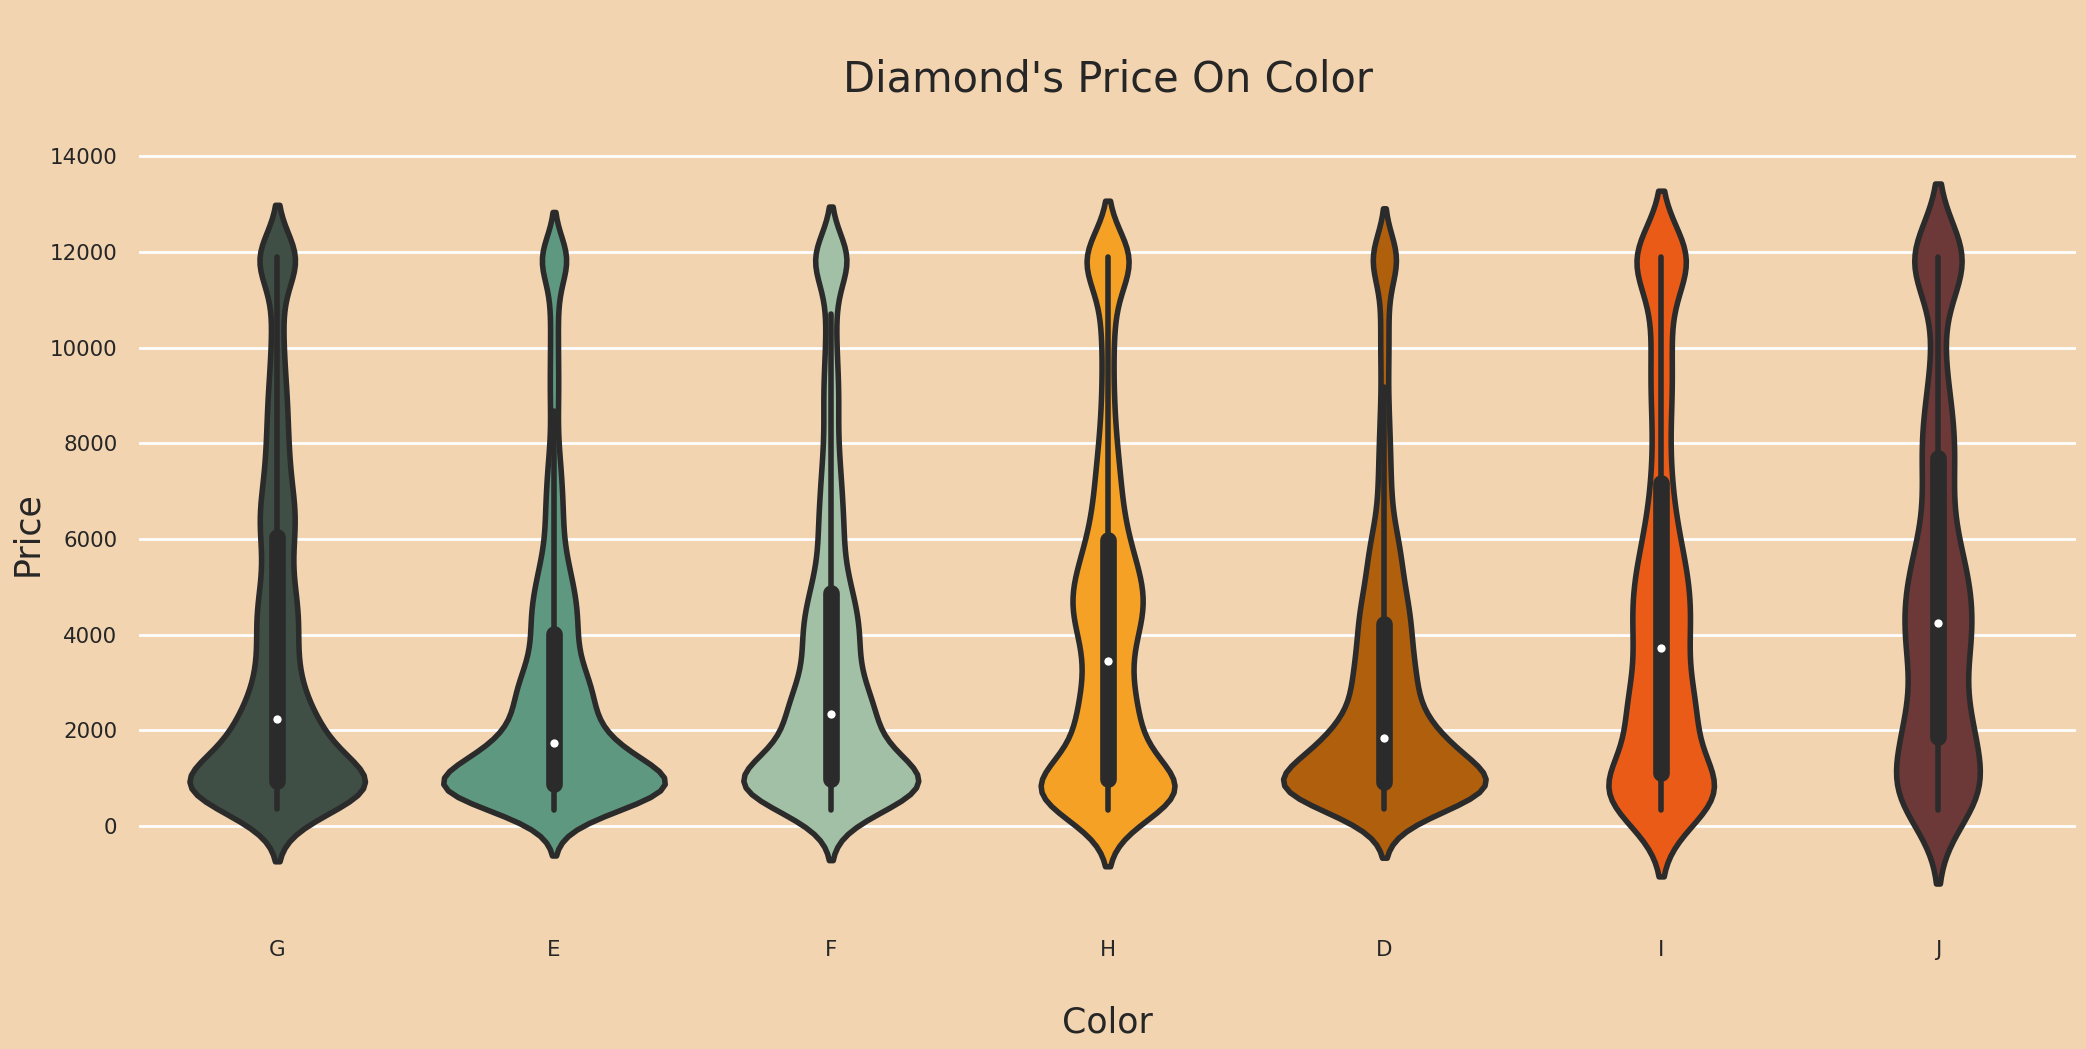

In [29]:
print("Let's have a look on the price distribution of diamond's color :")
plt.subplots(figsize=(25, 10))

p=sns.violinplot(x=df_qual["color"],y=df_quant["price"],order=df_qual["color"].value_counts().index,palette=["#3f4f45","#5e9880","#a2c0a6","#f5a126","#b05f0d","#ea5b17","#6c3938"],saturation=1,linewidth=4,edgecolor="black")
p.axes.set_title("\nDiamond's Price On Color\n",fontsize=30)
p.axes.set_xlabel("\nColor",fontsize=25)
p.axes.set_ylabel("Price",fontsize=25)

sns.despine(left=True, bottom=True)
plt.show()

## Statistical Hypothesis Testing

In [30]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [31]:
data = df[['cut', 'price']]

In [32]:
ideal = data[data['cut']=='Ideal']['price']
premium = data[data['cut']=='Premium']['price']
very_good = data[data['cut']=='Very Good']['price']
good = data[data['cut']=='Good']['price']
fair = data[data['cut']=='Fair']['price']

In [33]:
fvalue, pvalue = stats.f_oneway(ideal, premium, very_good, good, fair)
print('%.3f' % pvalue)

0.000


**If p-value < 0.05, we have to reject H0 hypothesis. It means that at least one group is different. We have to do Tukey test.**

In [34]:
# Tukey test
tukey = pairwise_tukeyhsd(endog=data['price'],
                          groups=data['cut'],
                          alpha=0.05)

print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1   group2   meandiff p-adj    lower      upper   reject
--------------------------------------------------------------
   Fair      Good -422.8333  0.002  -734.3156  -111.351   True
   Fair     Ideal -879.2044    0.0 -1159.5021 -598.9066   True
   Fair   Premium  241.5476 0.1428   -44.1596  527.2547  False
   Fair Very Good -360.9382 0.0056  -648.7073   -73.169   True
   Good     Ideal -456.3711    0.0  -627.6343 -285.1079   True
   Good   Premium  664.3809    0.0   484.4008  844.3609   True
   Good Very Good   61.8951 0.8887  -121.3406  245.1308  False
  Ideal   Premium 1120.7519    0.0  1002.6907 1238.8131   True
  Ideal Very Good  518.2662    0.0   395.2989  641.2335   True
Premium Very Good -602.4857    0.0   -737.329 -467.6425   True
--------------------------------------------------------------


In [35]:
hypotesis_testing(df, 'price', 'color')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     287.0
Date:                Tue, 01 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:23:14   Log-Likelihood:            -5.2149e+05
No. Observations:               53794   AIC:                         1.043e+06
Df Residuals:                   53787   BIC:                         1.043e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3174.4410     47.768     66.455      0.0

In [36]:
tukey = pairwise_tukeyhsd(endog=df['price'],
                          groups=df['color'],
                          alpha=0.05)

print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     D      E   -94.833 0.7288 -277.9786   88.3126  False
     D      F  552.3086    0.0  368.1595  736.4576   True
     D      G  826.9111    0.0  648.7712 1005.0509   True
     D      H 1308.4142    0.0  1118.587 1498.2413   True
     D      I 1907.3102    0.0 1696.0821 2118.5384   True
     D      J 2151.9744    0.0 1891.8661 2412.0827   True
     E      F  647.1416    0.0  480.4649  813.8182   True
     E      G   921.744    0.0  761.7315 1081.7566   True
     E      H 1403.2472    0.0 1230.3177 1576.1766   True
     E      I 2002.1432    0.0 1805.9608 2198.3257   True
     E      J 2246.8074    0.0 1998.7619 2494.8529   True
     F      G  274.6025    0.0  113.4424  435.7626   True
     F      H  756.1056    0.0  582.1138  930.0974   True
     F      I 1355.0017    0.0 1157.8821 1552.1213   True
     F      J 

In [37]:
hypotesis_testing(df, 'price', 'clarity')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     212.5
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          8.68e-313
Time:                        15:23:16   Log-Likelihood:            -5.2161e+05
No. Observations:               53794   AIC:                         1.043e+06
Df Residuals:                   53786   BIC:                         1.043e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3925.2757    144.629     

In [38]:
tukey = pairwise_tukeyhsd(endog = df['price'],
                          groups = df['clarity'],
                          alpha = 0.05)

print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
    I1     IF -1054.7062    0.0 -1576.1263   -533.286   True
    I1    SI1    70.8895 0.9998  -379.7545   521.5334  False
    I1    SI2  1132.1797    0.0   676.4282  1587.9313   True
    I1    VS1   -83.6643 0.9993  -541.4892   374.1605  False
    I1    VS2     2.4658    1.0  -448.9724   453.9041  False
    I1   VVS1 -1398.6727    0.0 -1879.4639  -917.8815   True
    I1   VVS2  -638.7432  0.001  -1108.098  -169.3885   True
    IF    SI1  1125.5956    0.0   824.5593   1426.632   True
    IF    SI2  2186.8859    0.0   1878.256  2495.5158   True
    IF    VS1   971.0418    0.0   659.3585  1282.7252   True
    IF    VS2   1057.172    0.0   754.9479  1359.3961   True
    IF   VVS1  -343.9665 0.0507  -688.4997     0.5666  False
    IF   VVS2   415.9629 0.0031    87.5778   744.3481   True
   SI1    SI2  1061.2903

## Feature Engineering

In [39]:
# select label
main_label = 'price'
# log10-transform label
df_quant[main_label] = df_quant[main_label].apply(lambda x: np.log10(float(str(x).replace('$', '').replace(',', ''))))
# log10-transfform carat and group into larger bins
df_quant['carat'] = df_quant['carat'].apply(lambda x: 1/50*round(50*np.log10(x)))
# exclude records with zero x, y, or z
df_quant = df_quant[df_quant['x']>0]
df_quant = df_quant[df_quant['y']>0]
df_quant = df_quant[df_quant['z']>0]
# create log10mean from x and y
df_quant['log10mean'] = (df_quant['x'] + df_quant['y']).apply(lambda x: 1/10*round(10*np.log10(0.5*x)))
# group depth and table into larger bins
df_quant['depth'] = df_quant['depth'].apply(lambda x: 5*round(1/5*x))
df_quant['table'] = df_quant['table'].apply(lambda x: 5*round(1/5*x))

In [40]:
from feature_engine.encoding import RareLabelEncoder

# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['cut', 'color', 'clarity']:
    df_qual[col] = df_qual[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=60, replace_with='Other', tol=20.0/df.shape[0])
    df_qual[col] = encoder.fit_transform(df_qual[[col]])

In [41]:
# drop unused columns
cols2drop = ['x', 'y', 'z']
df_quant = df_quant.drop(cols2drop, axis=1)

In [42]:
df_quant.shape

(53794, 5)

In [43]:
df_qual.shape

(53794, 3)

In [44]:
dict_cut= dict((k,v) for v, k in enumerate(('Fair', 'Good', 'Very Good', 'Premium', 'Ideal')))
dict_color= dict((k,v) for v, k in enumerate('DEFGHIJ'[::-1]))
dict_clarity= dict((k,v) for v, k in enumerate(('I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF')))

In [45]:
df_qual.replace({'cut': dict_cut}, inplace=True)
df_qual.replace({'color': dict_color}, inplace=True)
df_qual.replace({'clarity': dict_clarity}, inplace=True)
df_qual[['cut','color','clarity']] = df_qual[['cut','color','clarity']].astype('category')

In [46]:
df_quant.head()

,carat,depth,table,price,log10mean
0,-0.640,60,55,2.513,0.600
1,-0.680,60,60,2.513,0.600
2,-0.640,60,65,2.515,0.600
3,-0.540,60,60,2.524,0.600
4,-0.500,65,60,2.525,0.600


In [47]:
df_qual.head()

,cut,color,clarity
0,4,5,1
1,3,5,2
2,1,5,4
3,3,1,3
4,1,0,1


## Training and Testing data

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

In [49]:
data = pd.concat([df_qual, df_quant], axis = 1)
data.head()

,cut,color,clarity,carat,depth,table,price,log10mean
0,4,5,1,-0.640,60,55,2.513,0.600
1,3,5,2,-0.680,60,60,2.513,0.600
2,1,5,4,-0.640,60,65,2.515,0.600
3,3,1,3,-0.540,60,60,2.524,0.600
4,1,0,1,-0.500,65,60,2.525,0.600


In [50]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [51]:
X = data.drop("price", axis = 1)
y = data["price"]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Building Pipelines

In [53]:
#LR
lr_pipeline = Pipeline([
    ('scaler_1', StandardScaler()),
    ('lr_classifier', LinearRegression())
])

#KNN
knn_pipeline = Pipeline([
    ('scaler_2', StandardScaler()),
    ('knn_classifier', KNeighborsRegressor())
])
#DT
dt_pipeline = Pipeline([
    ('scaler_4', StandardScaler()),
    ('dt_classifier', DecisionTreeRegressor())
])
#RF
rf_pipeline = Pipeline([
    ('scaler_5', StandardScaler()),
    ('rf_classifier', RandomForestRegressor())
])

In [54]:
pipelines = [lr_pipeline, knn_pipeline,dt_pipeline, rf_pipeline]
models = ['Linear Regression', 'KNN','Decision Tree', 'Random Forest',]

In [55]:
for i in pipelines:
    i.fit(X_train, y_train)

In [56]:
cv_results = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results.append(cv_score)
    print("%s: %f " % (models[i], cv_score.mean()))

Linear Regression: -0.063848 
KNN: -0.065328 
Decision Tree: -0.053911 
Random Forest: -0.048557 


In [57]:
def bar_plot(data,col):
    v_c=data[col].value_counts()
    plt.figure(figsize=(12,9))
    sns.barplot(x=v_c.index,y=v_c.values)
    plt.ylabel('Frequency')
    plt.title(col)
    plt.show()
    print("{}:\n{}".format(col,v_c))

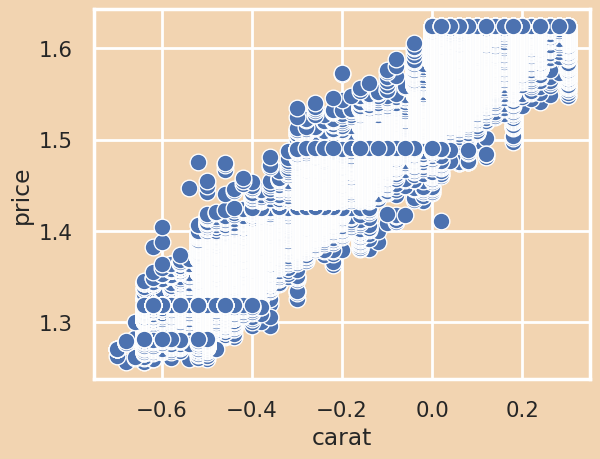

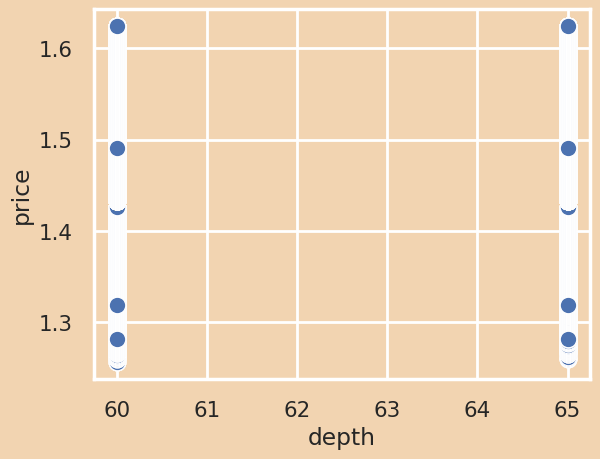

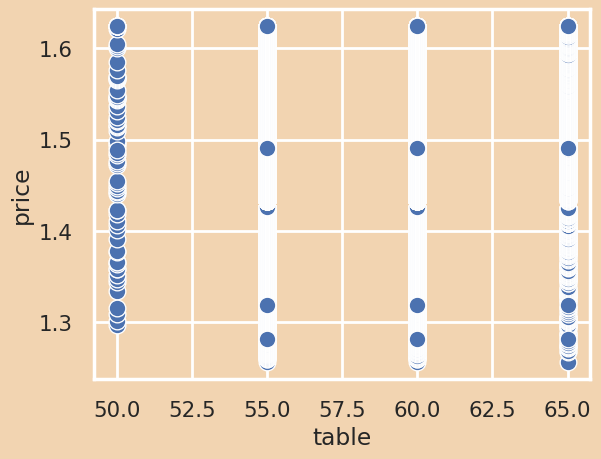

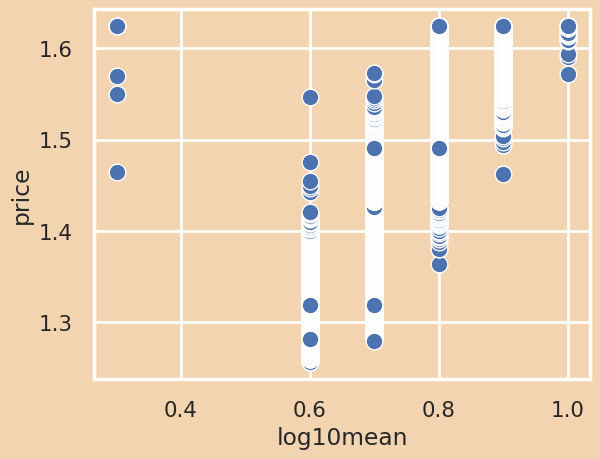

In [58]:
for col in df_quant:
    if col!='price':
        sns.scatterplot(x=data[col],y=np.log1p(data['price']))
        plt.show()